In [1]:
# Analysis and model of gold price
#
# Display plots inline in the notebook
%matplotlib inline

# Load standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from xgboost import XGBRegressor

# Statsmodels libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use joblib to save and load the model
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the data from the Federal Reserve FRED system
df = pd.read_csv('gold-usdebt-10yr-inflation-since1971.csv')

# print first few records
print(df.head())


        date                debt gold_price  treasury_rate_10  inflation
0  9/30/1971  398,129,744,455.54      40.95              6.14        4.1
1  9/30/1972  427,260,460,940.50      65.67              6.55        3.2
2  9/30/1973  458,141,605,312.09     120.17              7.09        7.4
3  9/30/1974  475,059,815,731.55     142.98              8.04       11.9
4  9/30/1975  533,189,000,000.00     165.17              8.43        7.9


## get basic dataset info

In [2]:
print(df.shape)
print()

print(df.info())
print()

print(df.describe(include='all'))
print()

# check for duplicates and missing data
print("Missing data:")
print(df.isnull().sum())
print()

print("Total duplicates:", df.duplicated().sum())
print()


(54, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              54 non-null     object 
 1   debt              54 non-null     object 
 2   gold_price        54 non-null     object 
 3   treasury_rate_10  54 non-null     float64
 4   inflation         54 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.2+ KB
None

             date                debt gold_price  treasury_rate_10  inflation
count          54                  54         54         54.000000  54.000000
unique         54                  54         53               NaN        NaN
top     9/30/1971  398,129,744,455.54   1,573.20               NaN        NaN
freq            1                   1          2               NaN        NaN
mean          NaN                 NaN        NaN          6.010370   4.002963
std           NaN                 

## Data Cleaning and Preprocessing

In [3]:
# Convert dates to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date')

# convert the debt to billions in new column
def clean_debt(debt):
    debt = debt.str.replace(',', '')  # Remove commas
    debt = debt.astype(float)
    debt = debt / 1000000000.0
    return debt

df['debt-b'] = clean_debt(df['debt'])
print(df['debt-b'].head())
print()

# convert gold price to floats
def clean_gold(gold):
    gold = gold.str.replace(',', '')  # Remove commas
    gold = gold.astype(float)
    return gold

df['gold_price'] = clean_gold(df['gold_price'])
print(df['gold_price'].tail(5))
print()

# No categorical data, so no need for one-hot encoding

# Since all of the data is from a reliable source,
# no need to check for outliers using IQR


0    398.129744
1    427.260461
2    458.141605
3    475.059816
4    533.189000
Name: debt-b, dtype: float64

49    1909.10
50    1785.30
51    1670.50
52    1900.30
53    2635.23
Name: gold_price, dtype: float64



## Get updated stats after cleaning

Statistical summary of numerical features:
                      date   gold_price  treasury_rate_10  inflation  \
count                   54    54.000000         54.000000  54.000000   
mean   1998-03-31 12:00:00   711.167963          6.010370   4.002963   
min    1971-09-30 00:00:00    40.950000          0.680000  -0.350000   
25%    1984-12-30 06:00:00   323.837500          3.562500   2.202500   
50%    1998-03-31 12:00:00   412.295000          5.860000   3.200000   
75%    2011-06-30 18:00:00  1182.375000          7.962500   4.592500   
max    2024-09-30 00:00:00  2635.230000         15.320000  12.600000   
std                    NaN   608.027704          3.334124   2.893143   

             debt-b  
count     54.000000  
mean    8977.508239  
min      398.129744  
25%     1634.975250  
50%     5469.669510  
75%    14283.719728  
max    35850.000000  
std     9508.413634  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Co

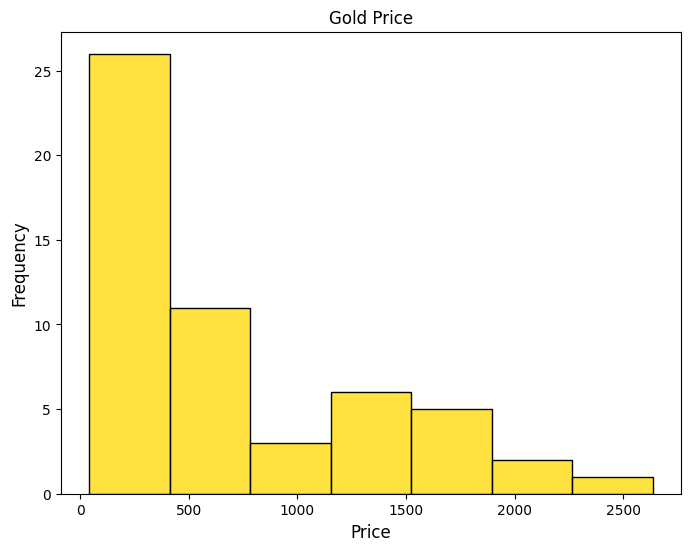

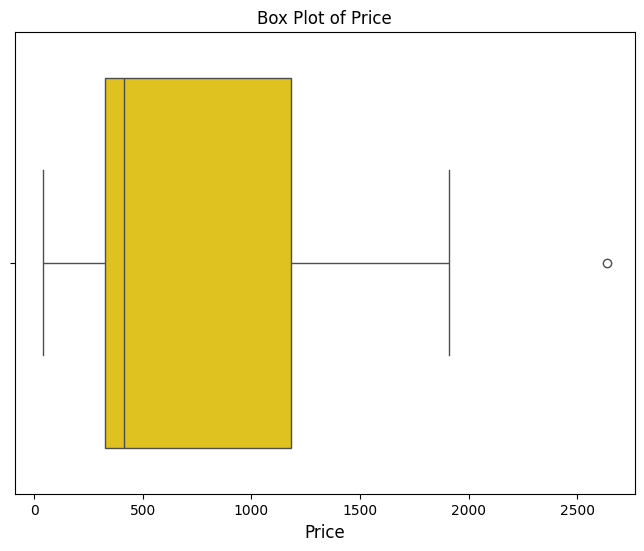

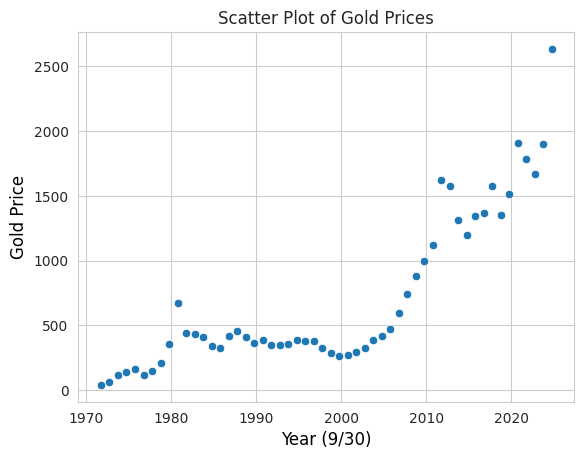

In [4]:
print("Statistical summary of numerical features:")
print(df.describe())
print()
print(df.info())
print()
print(df.head())

# Histogram of price
plt.figure(figsize=(8, 6))
sns.histplot(df['gold_price'], color='gold', edgecolor='black')
plt.title('Gold Price')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot of price
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['gold_price'], color='gold')
plt.title('Box Plot of Price', fontsize=12)
plt.xlabel('Price', fontsize=12)
plt.show()


# Scatter plot of price
sns.set_style("whitegrid")  # Set the style to whitegrid for gridlines
plt.figure()
ax = sns.scatterplot(x='date', y='gold_price', data=df)
# Set the x and y axis labels using matplotlib
ax.set_xlabel("Year (9/30)", fontsize=12, color="black")
ax.set_ylabel("Gold Price", fontsize=12, color="black")
plt.title("Scatter Plot of Gold Prices")
plt.show()

#df.plot(kind = 'scatter', x = 'date', y = 'gold_price')
#plt.show()

In [ ]:
lac

## Feature scaling and intial correlation analysis

In [5]:
# Drop the original Debt column (replaced by debt-b)
df = df.drop(['debt'], axis=1)

# Setting 'date' as the index
df.set_index('date', inplace=True)

# I considered regressors and time series models.
# I tried regressors first, and they could fit the data well, but could not
# forecast very well into the future.
# Then, I tried the SARIMAX time serie model from statsmodels.
# It was able to make forecasts with confidence intervals.
# Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors

# Correlation Analysis
corr_matrix = df.corr()
print("\nCorrelation of features with Price:")
print(corr_matrix['gold_price'].sort_values(ascending=False))
print()

# Feature Selection (target is price)
#X = df.drop(['gold_price'], axis=1)
#y = df['gold_price']

# Feature Scaling
#print("pre-scaled data", X.head())

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Save the fitted scaler for later use
#print(scaler)
#joblib.dump(scaler, 'scaler.pkl')

#print("scaled data", X_scaled)
#print()



Correlation of features with Price:
gold_price          1.000000
debt-b              0.951928
inflation          -0.288526
treasury_rate_10   -0.634155
Name: gold_price, dtype: float64



## Build a machine learning model and make predictions

future_df             treasury_rate_10  inflation  debt-b
date                                           
2025-09-25               4.2        2.7   37525
2026-09-25               3.8        2.7   39200
2027-09-25               3.8        2.7   40875

            treasury_rate_10  inflation      debt-b
date                                               
1971-09-30              6.14        4.1  398.129744
1972-09-30              6.55        3.2  427.260461
1973-09-30              7.09        7.4  458.141605
1974-09-30              8.04       11.9  475.059816
1975-09-30              8.43        7.9  533.189000
date
1971-09-30     40.95
1972-09-30     65.67
1973-09-30    120.17
1974-09-30    142.98
1975-09-30    165.17
Name: gold_price, dtype: float64
                               SARIMAX Results                                
Dep. Variable:             gold_price   No. Observations:                   54
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -325.275
Date:

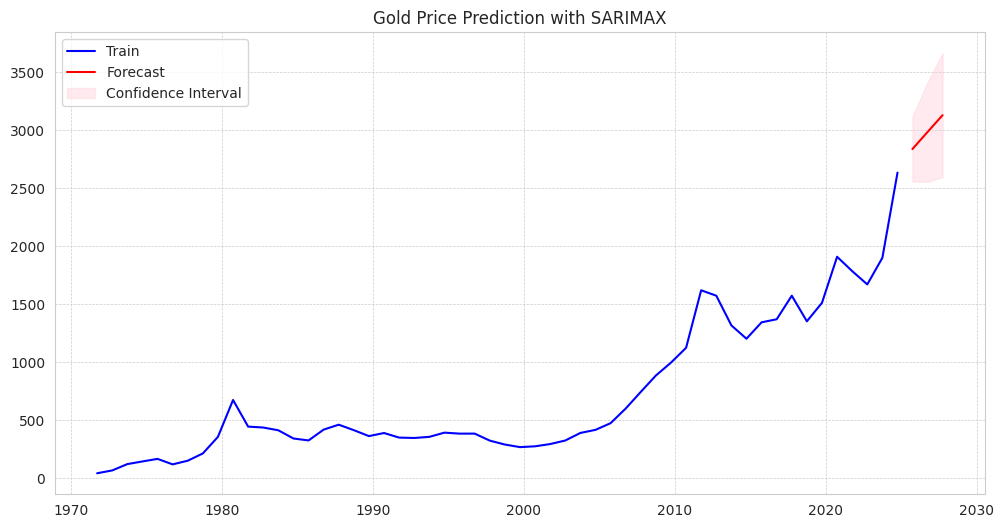

In [6]:
# Splitting data into train and test sets
#train, test = train_test_split(df, test_size=0.2, shuffle=False)
# Instead of splitting the data to make a train and test set, I chose to
# train on ALL of the data, then use the model to make future forecasts
# based on estimated future data
train = df

# Hypothesis for the next 3 years:
# - the debt grows at the mean rate from 2017-2024
# - inflation drops to 2.7% and stays there
# - 10 year treasury rate drops from 4.2% to 3.8%

future_data = {
    'date': ['2025-09-25', '2026-09-25', '2027-09-25'],
    'treasury_rate_10': [4.2, 3.8, 3.8],
    'inflation': [2.7, 2.7, 2.7],
    'debt-b': [37525, 39200, 40875]
}

# Convert to DataFrame
future_df = pd.DataFrame(future_data)

# Converting the 'date' column to datetime and setting as index
future_df['date'] = pd.to_datetime(future_df['date'])
future_df.set_index('date', inplace=True)

print("future_df", future_df.head())
print()

# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Try XGBRegressor
# Set up hyperparameter grid
#param_grid = {
#    'n_estimators': [100, 300, 500],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 7]
#}

# Initialize and perform grid search
#grid_search = GridSearchCV(
#    estimator=XGBRegressor(random_state=42),
#    param_grid=param_grid,
#    scoring='r2',
#    cv=5,
#    n_jobs=-1,
#    verbose=1
#)

# Model Performance on Entire Dataset:
# Mean Absolute Error: 99.77641878995028
# R-squared Score: 0.9208896315357188

#Try RandomForestRegressor
# Set up hyperparameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of trees in the forest
#    'max_depth': [None, 10, 20, 30],  # Depth of trees; 'None' means grow until pure leaves
#    'max_features': ['auto', 'sqrt'],  # Number of features
#}

# Initialize and perform grid search
#grid_search = GridSearchCV(
#    estimator=RandomForestRegressor(random_state=42),
#    param_grid=param_grid,
#    scoring='r2',
#    cv=5,
#    n_jobs=-1,
#    verbose=1
#)

# Model Performance on Entire Dataset:
# Mean Absolute Error: 74.12481969696928
# R-squared Score: 0.9658519315088969


# Fit the grid search to the training data
#grid_search.fit(X_train, y_train)

# Get the best model from grid search
#best_model = grid_search.best_estimator_

# Make predictions on the test set
#y_pred = best_model.predict(X_test)


# Evaluate the model's performance
#mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#print(f"\nModel Performance on Entire Dataset:")
#print(f"Mean Absolute Error: {mae}")
#print(f"R-squared Score: {r2}")


# Defining the SARIMAX model with exogenous variables
exogenous_train = train[['treasury_rate_10', 'inflation', 'debt-b']]
# exogenous_test = test[['treasury_rate_10', 'inflation', 'debt-b']]
y_train = train['gold_price']
#y_test = test['gold_price']

########
print(exogenous_train.head())
#print(exogenous_test.head())
print(y_train.head())
#print(y_test.head())


# Fitting the SARIMAX model
model = SARIMAX(
    y_train,
    exog=exogenous_train,
    order=(1, 1, 1),  # Adjust based on exploratory analysis
    seasonal_order=(0, 0, 0, 0),  # Assuming seasonality is yearly (12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = model.fit(disp=False)

# Printing summary of the fitted model
print(sarimax_fit.summary())


# Forecasting
forecast_steps = len(future_df)
forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=future_df)

# Extracting forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

print(forecast_values)

# Displaying results
#results = pd.DataFrame({
#    'Actual': y_test,
#    'Forecasted': forecast_values,
#    'Lower CI': conf_int.iloc[:, 0],
#    'Upper CI': conf_int.iloc[:, 1]
#})
#print(results)

plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label='Train', color='blue')
#plt.plot(future_df.index, y_test, label='Test', color='green')
plt.plot(future_df.index, forecast_values, label='Forecast', color='red')
plt.fill_between(future_df.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')
plt.title('Gold Price Prediction with SARIMAX')
plt.show()



## Results analysis

In summary, this SARIMAX model suggests that US debt has a statistically significant positive effect on the target variable, while the other exogenous variables are not statistically significant. Because kurtosis was 4.8, well above the normal distribution value of 3, prices have a longer tail and more room for fluctuations. This created a pretty wide confidence interval in the predictions.